<h1> <div align="center"><a> Проект «Определение возраста покупателей» </a></div>    

<font size="4"><b> Описание проекта </b></font>

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

<font size="4"><b> Цель проекта </b></font>

Постройте модель, которая по фотографии определит приблизительный возраст человека. Целевое значение MAE на тестовой выборке 8.

<font size="4"><b> Описание данных </b></font>

Данные представлены одна папка со всеми изображениями и один датасет со следующими столбцами:
 * real_age - целевой признак;
 * file_name - название файла в папке с фотографиями

## Исследовательский анализ данных
### Анализ выборки

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import random 
import os

In [2]:
labels = pd.read_csv("/datasets/faces/labels.csv")
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# выведем основные свойства выборки
labels.info()       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
# проверка на наличие дубликатов
labels.duplicated().sum()

0

**Основные выводы**
* для обучения нейросети на основе изображений размер выборки достаточно небольшой (7591 фотография) - эту проблему можно попробовать решить аугментацией;
* пропусков и дубликатов не обнаружено.

### Анализ распределения возрастов

In [7]:
# выведем основные характеристики выборки
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


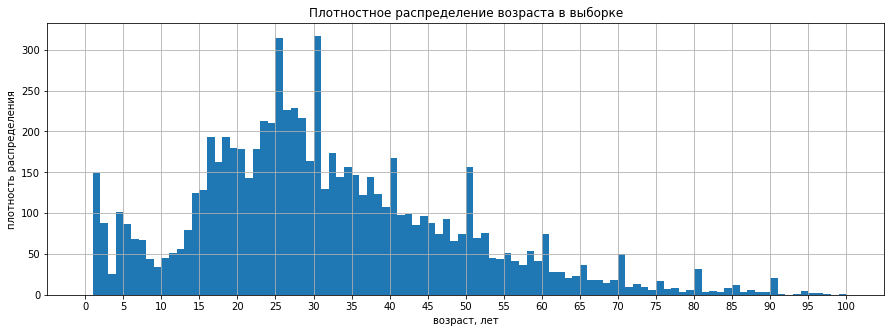

In [8]:
# построим гистограмму распределения возраста 
labels['real_age'].hist(bins=100, range=(0, 100), figsize=(15, 5), density=False)
plt.xlabel('возраст, лет')
plt.ylabel('плотность распределения')
plt.title("Плотностное распределение возраста в выборке")
plt.xticks(np.arange(0, 101, step=5))
plt.show()

In [9]:
# выведем топ-10 возрастов, которые представлены в нашей выборке максимально и минимально.
display(labels['real_age'].value_counts().head(10),
        labels['real_age'].value_counts().sort_values(ascending = True).head(10))

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

97     1
93     1
91     1
100    1
96     2
95     2
88     3
83     3
81     3
78     3
Name: real_age, dtype: int64

**Основные выводы**
 * представлены люди самых разных возрастов от 1 года и до 100 лет включительно, средний возраст 31 год, медианный - 29 лет;
 * на гистограмме наблюдаем пики в районе круглых десятков начиная с 30 - это может быть связано, что часть фотографий была размечена на основе визуального анализа кратно 5 - 10 годам (есть также небольшие пики начиная с возраста 65 + 10 лет*n);
 * большая часть возрастов представлены в диапазоне от 15 до 40 лет;
 * хуже всего представлены люди возрастом 80+ (по 1 - 3 фотографии), что может снизить качество модели в части предсказания людей этой возрастной группы - одним из способой решения данной проблемы может стать аугментация.

### Анализ фотографий

In [47]:
# добавим столбцы с размерами изображений и их атрибутами (ширина и высота) 
%%time
def image_size(row):
    name = row['file_name']
    return os.stat('/datasets/faces/final_files/' + name).st_size

def image_attr(row):
    name = row['file_name']
    image = Image.open('/datasets/faces/final_files/' + name) 
    return image.size 


labels['image_size'] = labels.apply(image_size, axis=1)
labels['image_attr'] = labels.apply(image_attr, axis=1)
labels.tail()

,file_name,real_age,image_size
7586,007608.jpg,14,4718
7587,007609.jpg,37,8415
7588,007610.jpg,28,2974
7589,007611.jpg,20,10760
7590,007612.jpg,47,10495


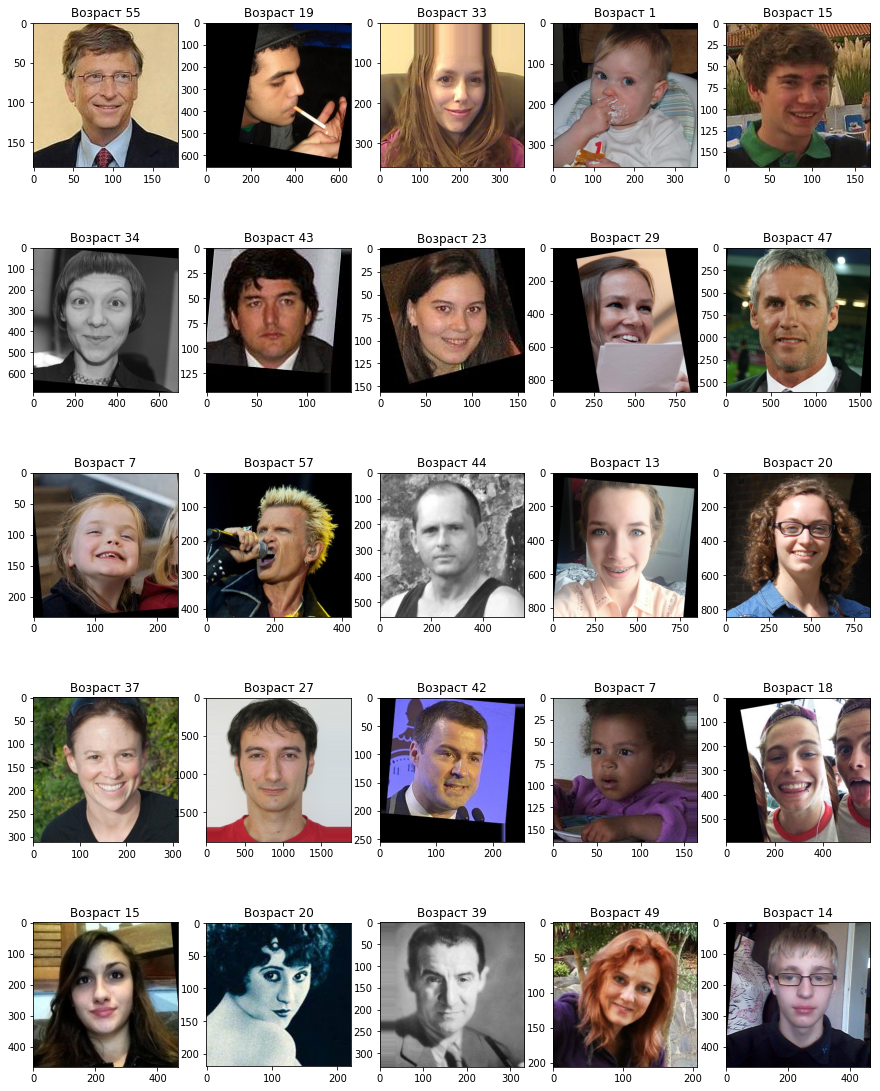

In [58]:
# выведем ряд случайных фотографий с указанием возраста, чтобы получить представление о датасете
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,20))

for ax in axes.flat:
    for i in list(np.random.randint(0, labels.shape[0], 1)):
        name = str(str(0)*(6-len(str(i))) + str(i) + '.jpg')
        age = labels.query(' file_name == @name')['real_age'].values[0]
        ax.set(title= f'Возраст {age}')
        image = Image.open('/datasets/faces/final_files/' + name) 
        ax.imshow(image)        

plt.show()

**Анализ фотографий**
 * фотографии в выборке имеют разный размер - с помощью загрузчика данных ImageDataGenerator все изображения будут приведены к одному размеру;
 * большая часть фотографий цветные, но встречаются и черно-белые;
 * большинство фотографий предобработаны: в них проведена обрезка по размеру лица, в отдельных случаях изменен поворот, чтобы было видно человек в анфас;
 * однако встречаются фотографии, где в кадре находится сразу несколько лиц, посторонние предметы (например, машина, рука, сигарета, микрофон) или лицо занимает лишь небольшую часть (например, женщина 42 лет, сфотографированная в классе) - все эти факторы негативно влияют на обучение модели;
 * довольно часто попадаются фотографий знаменитостей, что может ухудшить обучение, посколько эти люди уделяют своей внешности максимально много времени и почти всегда выглядят моложе своего возраста;
 * попадаются нечеткие, размытые фотографии и даже с дефектами, что также может негативно сказаться на качестве модели. 

### Общие выводы

 1. для обучения нейросети на основе изображений размер выборки достаточно небольшой (7591 фотография) - эту проблему можно попробовать решить аугментацией;
 2. представлены люди самых разных возрастов от 1 года и до 100 лет включительно, средний возраст 31 год, медианный - 29 лет;
 3. на гистограмме наблюдаем пики в районе круглых десятков начиная с 30 - это может быть связано, что часть фотографий была размечена на основе визуального анализа кратно 5 - 10 годам (есть также небольшие пики начиная с возраста 65 + 10 лет*n);
 4. хуже всего представлены люди возрастом 80+ (по 1 - 3 фотографии), что может снизить качество модели в части предсказания людей этой возрастной группы - одним из способой решения данной проблемы может стать аугментация.
 5. большинство фотографий предобработаны: в них проведена обрезка по размеру лица, в отдельных случаях изменен поворот, чтобы было видно человек в анфас - это положительно влияет на качество будущей модели;
 6. встречаются фотографии, которые негативно могут влиять на качество обучения по той или иной причине:
   - в кадре находится сразу несколько лиц;
   - в кадре имеются посторонние предметы (например, машина, рука, сигарета, микрофон);
   - лицо занимает лишь небольшую часть (например, женщина 42 лет, сфотографированная в классе);
   - фотографий знаменитостей, посколько эти люди уделяют своей внешности максимально много времени и почти всегда выглядят моложе своего возраста;
   - нечеткие, размытые фотографии и даже с дефектами.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

 ## В процессе обучения были использованы разные методы аугментации (flip, rotation, shift, brightness, zoom), однако их применение не дало уменьшения целевой метрики. В связи с этим в финальные параметры модели она не была включена.

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        labels,
        directory = path + '/final_files',
        x_col='file_name',
        y_col = 'real_age',                                    
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)    
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        labels,
        directory = path + '/final_files',
        x_col='file_name',
        y_col = 'real_age',                                    
        batch_size=16,                                             
        class_mode='raw',
        subset='validation',
        seed=12345)    
    return test_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch = len(train_data),
              validation_steps = len(test_data),
              verbose=2)     
              
    return model 
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 49s - loss: 200.3715 - mae: 10.6091 - val_loss: 309.3455 - val_mae: 13.0512
Epoch 2/10
356/356 - 41s - loss: 104.2745 - mae: 7.8091 - val_loss: 211.2916 - val_mae: 11.3122
Epoch 3/10
356/356 - 40s - loss: 66.8485 - mae: 6.2047 - val_loss: 97.6613 - val_mae: 7.6487
Epoch 4/10
356/356 - 40s - loss: 44.4513 - mae: 5.1416 - val_loss: 93.1969 - val_mae: 7.2481
Epoch 5/10
356/356 - 40s - loss: 31.6078 - mae: 4.3385 - val_loss: 123.6362 - val_mae: 8.3640
Epoch 6/10
356/356 - 40s - loss: 22.6626 - mae: 3.6612 - val_loss: 95.5891 - val_mae: 7.5155
Epoch 7/10
356/356 - 40s - loss: 17.9933 - mae: 3.2812 - val_loss: 84.6170 - val_mae: 6.9308
Epoch 8/10
356/356 - 40s - loss: 14.6841 - mae: 2.9458 - val_loss: 121.5408 - val_mae: 8.8391
Epoch 9/10
356/356 - 40s - loss: 13.3559 - mae: 2.7863 - val_loss: 89.1863 - val_mae: 7.2625
Epoch 10/10
356/356 - 40s - loss: 11.8719 - mae: 2.6521 - val_loss: 75.8753 - val_mae: 6.5467
119/119 - 10s - loss: 75.8753 - mae: 6.5467
Test MAE: 6.5467
```

## Анализ обученной модели

**Основные выводы:**
 1. мы построили регрессионную модель для определения возраста человека по фотографии с помощью метода обучение с учителем;
 2. обученная модель продемонстрировала MAE на валидационной выборке 6.5, что ниже целевого значения 8.
 3. были использованы следующие ключевые допущения: 
  - применена архитектура ResNet50; 
  - использован алгоритм Adam с lr=0.0003; 
  - количество изображений в батче - 16; 
  - выборка поделена на обучающую и валидационную в соотношении 3:1; 
  - функция активации Relu;
  - аугментация не дала уменьшения целевой метрики, поэтому в финальные параметры модели она не была включена.